<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# помним про PEP-8
# импорты из стандартной библиотеки
import warnings

In [2]:
from IPython.core.display import display, HTML

C:\Users\Games\AppData\Local\Temp\ipykernel_101644\2058709175.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
display(HTML("<style>.container { width:88% !important; }</style>"))

In [4]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split,
    cross_val_score,
    TimeSeriesSplit
)

from time import time

In [5]:
RANDOM_STATE = 12345
ITERATIONS = 100
VERBOSE = 1
N_JOBS=-1

In [6]:
try:
    forsen = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    forsen = pd.read_csv('C:/Users/Games/Downloads/taxi.csv', index_col=[0], parse_dates=[0])

In [7]:
forsen.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [8]:
forsen.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим, в хронологическом ли порядке расположились индексы даты и времени.

In [9]:
forsen.index.is_monotonic

True

Проверим наличие пустых значений.

In [10]:
forsen.isna().sum()

num_orders    0
dtype: int64

Проведём ресемплирование по одному часу. Поскольку предсказываем количество заказов такси на следующий час, аггрегируем суммы значений.

In [11]:
forsen = forsen.resample('1H').sum()

In [12]:
f"Временной промежуток данных: {forsen.index.min()} - {forsen.index.max()}"

'Временной промежуток данных: 2018-03-01 00:00:00 - 2018-08-31 23:00:00'

Временной промежуток с 1 марта по 31 августа.

Проверим, всё ли задуманное удалось выполнить.

In [13]:
forsen.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [14]:
forsen.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

На всякий случай ресемплируем дополнительно датасет по одному дню и одной неделе, ниже просто дополнительно построим их графики.  
Для ресемплированного датасета по часу также сразу попробуем сгладить значения скользящим средним, чтобы получить более адекватную картину по общей картине с заказами такси на протяжении всего периода.  
Вдобавок добавим на график стандартное отклонение и посмотрим как меняется среднее и дисперсия.  
Также сделаем копию исходного ресемплированного по часу датасета для доп. признаков для построения графиков.

In [15]:
forsen_hourly = forsen.copy()

In [16]:
forsen_daily = forsen.resample('1D').sum()
forsen_weekly = forsen.resample('1W').sum()

In [17]:
forsen_hourly['rolling_mean'] = forsen_hourly.rolling(24).mean()
forsen_hourly['rolling_std'] = forsen_hourly['num_orders'].rolling(24).std() 

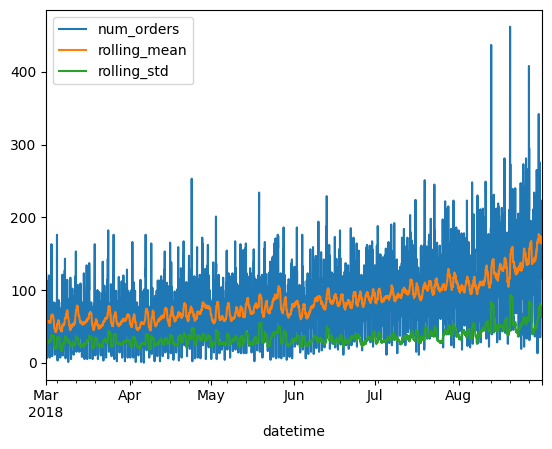

In [18]:
forsen_hourly.plot()
plt.show()

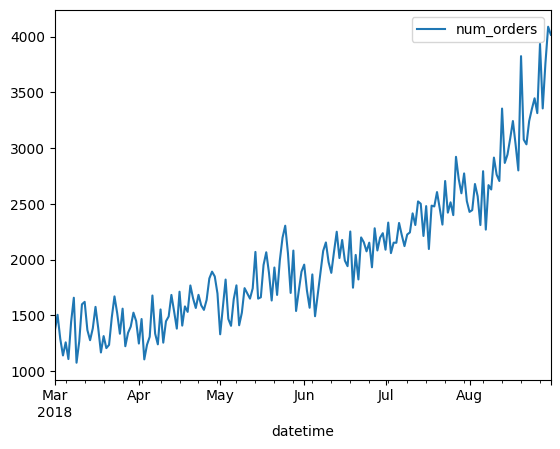

In [19]:
forsen_daily.plot()
plt.show()

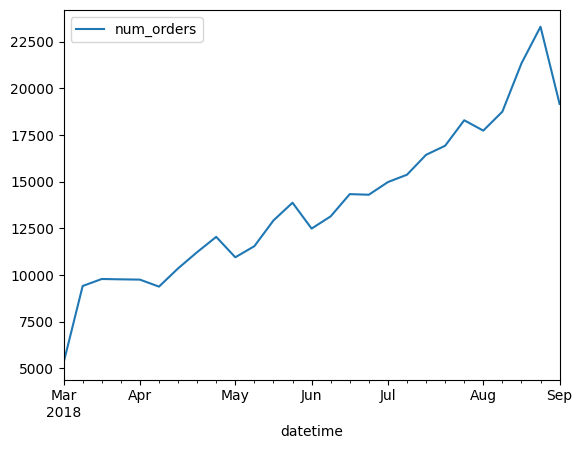

In [20]:
forsen_weekly.plot()
plt.show()

На основе трёх графиков выше сделаем промежуточные выводы:
* Наш временной ряд не стохастический, меняется среднее значение, дисперсия;
* Ежедневное кол-во заказов такси с начала периода (март) увеличилось более чем в два раза, с ~1500 ед. до ~3500 ед.;
* Аналогично с еженедельным кол-вом заказов, ~10 тыс. в марте, ~21 тыс. в августе; 

Разложим данные на три составляющие: тренд, сезонность и остаток за весь период. 

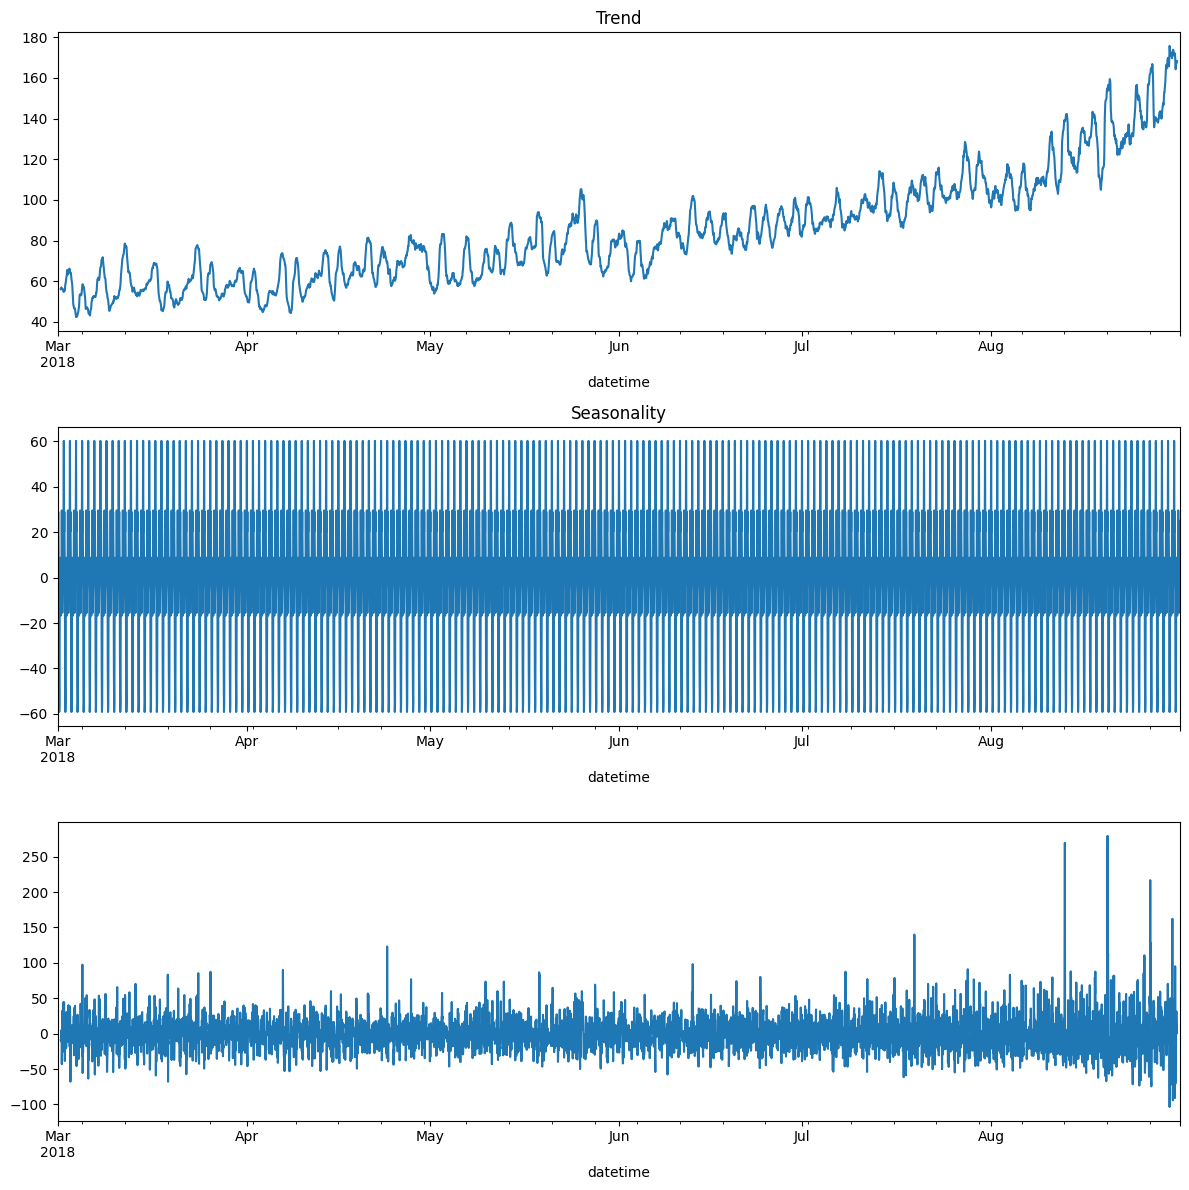

In [21]:
full_decompose = seasonal_decompose(forsen_hourly['num_orders'])
plt.figure(figsize=(12,12))
plt.subplot(311)

full_decompose.trend.plot(ax=plt.gca())

plt.title('Trend')
plt.subplot(312)

full_decompose.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)

full_decompose.resid.plot(ax=plt.gca())

plt.title=('Residuals')
plt.tight_layout()

Тренд показывает линейный рост количества заказов со временем. По получившемуся графику тренда видим, что чем дальше от марта 2018 г. тем больше становится кол-во заказов такси.  
Распределение сезонной части выглядит стационарным в текущем интервале. Далее построим график сезонности с более узкими интервалами.  

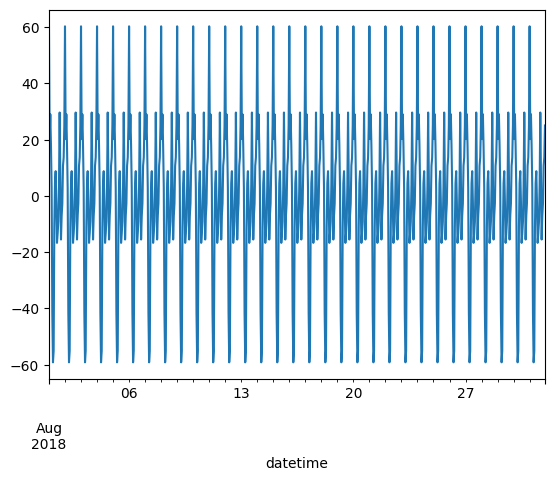

In [22]:
data_seasonal = full_decompose.seasonal['2018-08-01':'2018-08-31']
data_seasonal.plot()
plt.show()

Распределение сезонной части выглядит стационарным в интервале суток. Поздно ночью/рано утром такси почти не заказывают, пик ближе к вечеру и полуночи.
Исследуем сезонность чуть глубже, чтобы убедиться, что предыдущие выводы верны.

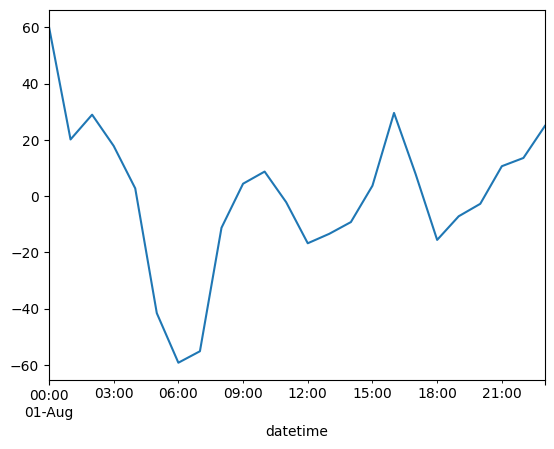

In [23]:
data_seasonal = full_decompose.seasonal['2018-08-01':'2018-08-01']
data_seasonal.plot()
plt.show()

Пик заказов в полночь. Наименьшее кол-во рано утром (6 утра). Приближаться к пику кривая на графике начинает ближе к вечеру.

## Обучение

Создадим доп. обучающие признаки (day, dayofweek, а также признаки для скользящего среднего rolling_mean (с размером окна rolling_mean_size), и lag_i для признаков отстающего значения) для последующего обучения модели.

In [24]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['hour'] = data.index.hour
    df['day'] = data.index.day
    df['dayofweek'] = data.index.dayofweek
    df['month'] = data.index.month
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

df = make_features(forsen, 24, 50)

Взяли значение макс. лага в 24, потому что в сутках 24 часа, а значение скользящего в 50 для большего сглаживания.

In [25]:
df.head(51)

,num_orders,hour,day,dayofweek,month,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,1,3,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,5,1,3,3,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,6,1,3,3,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,7,1,3,3,12.0,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,8,1,3,3,15.0,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разделим новый полученный датасет на обучающую и тестовую выборки в соотношении 1 к 10.

In [26]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

Определим обучающие признаки и целевой признак у обучающей и тестовой выборок.

In [27]:
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'],axis=1)
y_test = test['num_orders']

Проверим, правильно ли друг за другом следуют объекты тренировочной и тестовой выборок.

In [28]:
display(X_train.index.max())

Timestamp('2018-08-13 13:00:00', freq='H')

In [29]:
display(X_test.index.min())

Timestamp('2018-08-13 14:00:00', freq='H')

In [30]:
print('Размер обучающей выборки: {} объектов, {} признаков'.format(X_train.shape[0], X_train.shape[1]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(X_test.shape[0], X_test.shape[1]))

Размер обучающей выборки: 3924 объектов, 29 признаков
Размер тестовой выборки: 442 объектов, 29 признаков


**Linear Regression**

Добавим значение для кросс-валидации для корректной работы с временными рядами.

In [31]:
tscv = TimeSeriesSplit(n_splits=10)

In [32]:
%%time


lr_model = LinearRegression(n_jobs=N_JOBS)

lr_result = cross_val_score(lr_model,
                            X_train,
                            y_train,
                            cv=tscv,
                            scoring='neg_mean_squared_error').mean()

print('RMSE for LinearRegression: ', (-lr_result) ** 0.5)

RMSE for LinearRegression:  26.747162552654494
CPU times: total: 141 ms
Wall time: 115 ms


In [33]:
lr_rmse_score = (-lr_result) ** 0.5

Значение RMSE линейной регрессии на кросс-валидации по тренировочным данным - 26,75.

**Catboost**

Напишем функцию для кросс-валидации наших моделей градиетного бустинга Catboost и LightGBM.

In [35]:
def train_model(model, parameters, features, target):
    
    model_random = RandomizedSearchCV(estimator=model,
                                      param_distributions=parameters, # используем параметры
                                      n_iter=ITERATIONS, 
                                      scoring='neg_root_mean_squared_error', # используем необходимую метрику
                                      cv=tscv, 
                                      verbose=VERBOSE, 
                                      random_state=RANDOM_STATE)
    
    # посмотрим время обучения 
    start = time()
    model_random.fit(features, target)
    print('RandomizedSearchCV подбирал параметры %.2f секунд' %(time() - start))

    # высчитаем метрики
    rmse = model_random.best_score_ * -1
    
    print('Лучшие параметры:', model_random.best_params_)
    print('RMSE обученной модели:', rmse)
    
    return model_random, rmse

In [36]:
parameters = {'depth': [6, 8, 10],
              'learning_rate': [0.01, 0.1, 0.5, 1],
              'iterations': [100, 200, 400]
              }

cat = CatBoostRegressor(verbose=False, task_type='GPU') 

cat_random, rmse_cat = train_model(cat, parameters, X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


C:\Users\Games\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV подбирал параметры 688.97 секунд
Лучшие параметры: {'learning_rate': 0.1, 'iterations': 200, 'depth': 6}
RMSE обученной модели: 23.694505265364125


**LightGBM**

In [38]:
%%time

rand_lgbm_param = {
    'max_depth': [5, 10, 15, 25],
    'learning_rate': [0.01, 0.1, 0.15],
    'num_leaves': [10, 50, 100]
}

gbm = lgb.LGBMRegressor(boosting_type='gbdt',
                         objective = 'regression',
                         metric = 'RMSE')

gbm_random, rmse_gbm = train_model(gbm, rand_lgbm_param, X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


C:\Users\Games\anaconda3\envs\ds_practicum_env\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 36 is smaller than n_iter=100. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2050
[LightGBM] [Info] Number of data points in the train set: 364, number of used features: 28
[LightGBM] [Info] Start training from score 56.184066
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

## Тестирование

In [40]:
result = pd.DataFrame(
    [lr_rmse_score, rmse_cat, rmse_gbm], 
    index=['LinearRegression', 'Catboost', 'LGBM'], 
    columns=['RMSE']
)
result

,RMSE
LinearRegression,26.747163
Catboost,23.694505
LGBM,23.885615


Из трёх моделей наименьшая квадратичная ошибка получилась у Catboost. Далее протестируем её с уже известными нам наилучшими гиперпараметрами на тестовой выборке. Заодно отобразим на графике предсказанные моделью значения и реальные данные тестовой выборки.

CPU times: total: 15.6 ms
Wall time: 18 ms


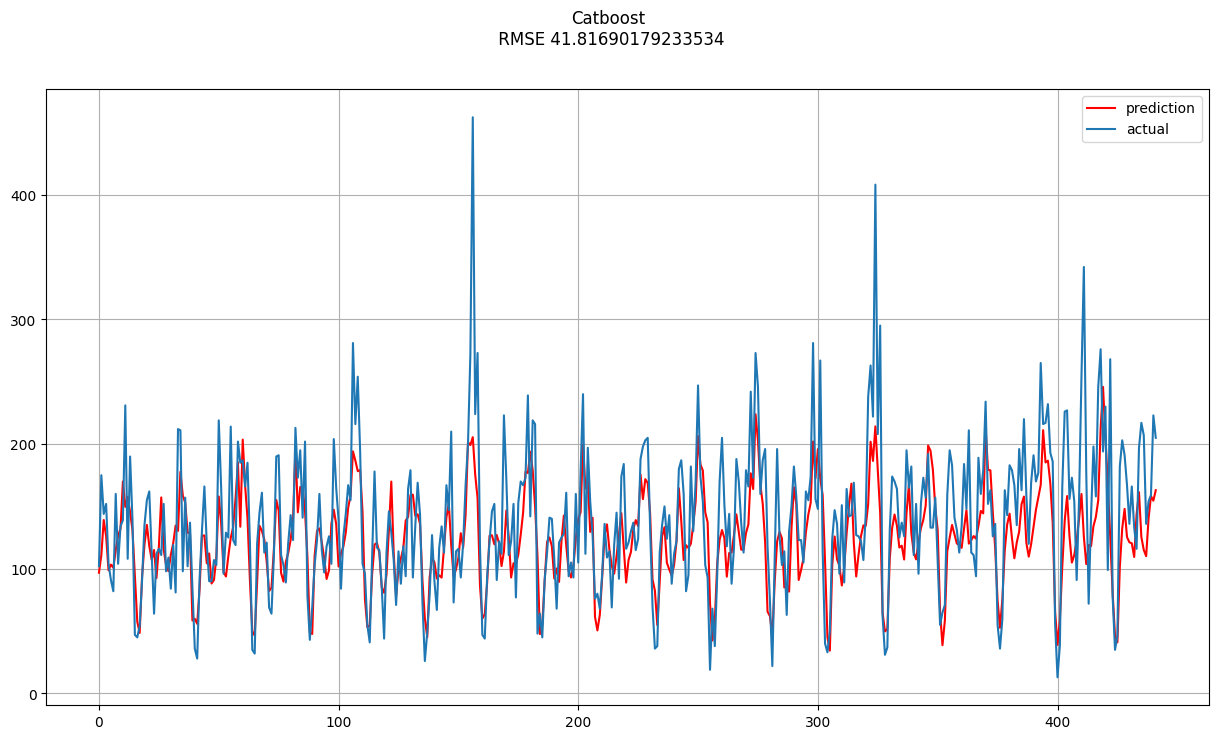

In [43]:
%%time

cbt_prediction = cat_random.predict(X_test)
metric_test = mean_squared_error(y_test, cbt_prediction, squared=False)
metric_test

plt.figure(figsize=(15, 8))
plt.plot(cbt_prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.suptitle(f"Catboost\n RMSE {metric_test}")
plt.grid(True)

Значение метрики на тестовой выборке (41,82) получилось ниже требуемого **порога в 48**. Задание выполнено.

**Вывод**

Загрузив датасет и проведя ресемплирование, в ходе исследования мы выяснили, что ежедневное кол-во заказов такси с начала периода (март) увеличилось более чем в два раза, с ~1500 ед. до ~3500 ед.; аналогично с еженедельным кол-вом заказов, ~10 тыс. в марте, ~21 тыс. в августе;  

Ежедневное кол-во заказов такси с начала периода (март) увеличилось более чем в два раза, с ~1500 ед. до ~3500 ед.;  

Аналогично с еженедельным кол-вом заказов, ~10 тыс. в марте, ~21 тыс. в августе;  
Также мы узнали, что распределение сезонной части выглядит стационарным в интервале суток. Поздно ночью/рано утром такси почти не заказывают, пик ближе к вечеру и полуночи. Исследуем сезонность чуть глубже, чтобы убедиться, что предыдущие выводы верны. Пик заказов в полночь. Наименьшее кол-во рано утром (6 утра). Приближаться к пику кривая на графике начинает ближе к вечеру.

Проведя исследование и придя к вышеперечисленным выводам, далее мы разделили выборку, на кроссвалидации провели сравнение качества трёх моделей: 1 модели линейной регрессии, 2 моеделй градиентного бустинга (Catboost и LightGBM).

По результатам кросс-валидации лучше всего себя показала модель градиентного бустинга Catboost, однако подбирала гиперпараметры и обучалась эта модель дольше, нежели LGBM. Тем не менее, при тестировании модели на тестовой выборке **нам удалось получить значение квадратичной ошибки (41,82) ниже требуемого порога в 48.**